# Imports

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")


# Load datasets

In [2]:
dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()



In [3]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]

In [4]:
#trying to shift these 1h backwards
hour_cols = [
    'clear_sky_energy_1h:J',
    'diffuse_rad_1h:J',
    'direct_rad_1h:J',
    'fresh_snow_1h:cm',
    'fresh_snow_3h:cm',
    'fresh_snow_6h:cm',
    'fresh_snow_12h:cm',
    'fresh_snow_24h:cm',
]

## Cleaning X

Found a hole in the X data on location A

1|2
---|---
![1](./feature_cleaning/img/X_A_1.png) | ![2](./feature_cleaning/img/X_A_2.png)

This prevents our aggregation method to match the target data after these data points

Trying to remove this point and reindex to fix the issue. 

In [5]:
print("A: \n", len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 01:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))

A: 
 136245
Index([118668], dtype='int64')
136244


Same problem for B-set at `2022-05-02 21:00:00` and C-set at `2022-04-25 21:00:00`

In [6]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))

B: 
 134505
Index([116916], dtype='int64')
134504
C: 
 134401
Index([116244], dtype='int64')
134400


In [7]:
for col in hour_cols:
    XTRA[col].shift(-4)
    XTRB[col].shift(-4)
    XTRB[col].shift(-4)

## Cleaning Y-data

`B` targets and `C` targets have lots of static values that seems like invalid data. 

Removing them with function below

[]
[635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 707, 708, 709, 710, 711, 712, 713, 1348, 1349, 1350, 1351, 1352, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256,

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

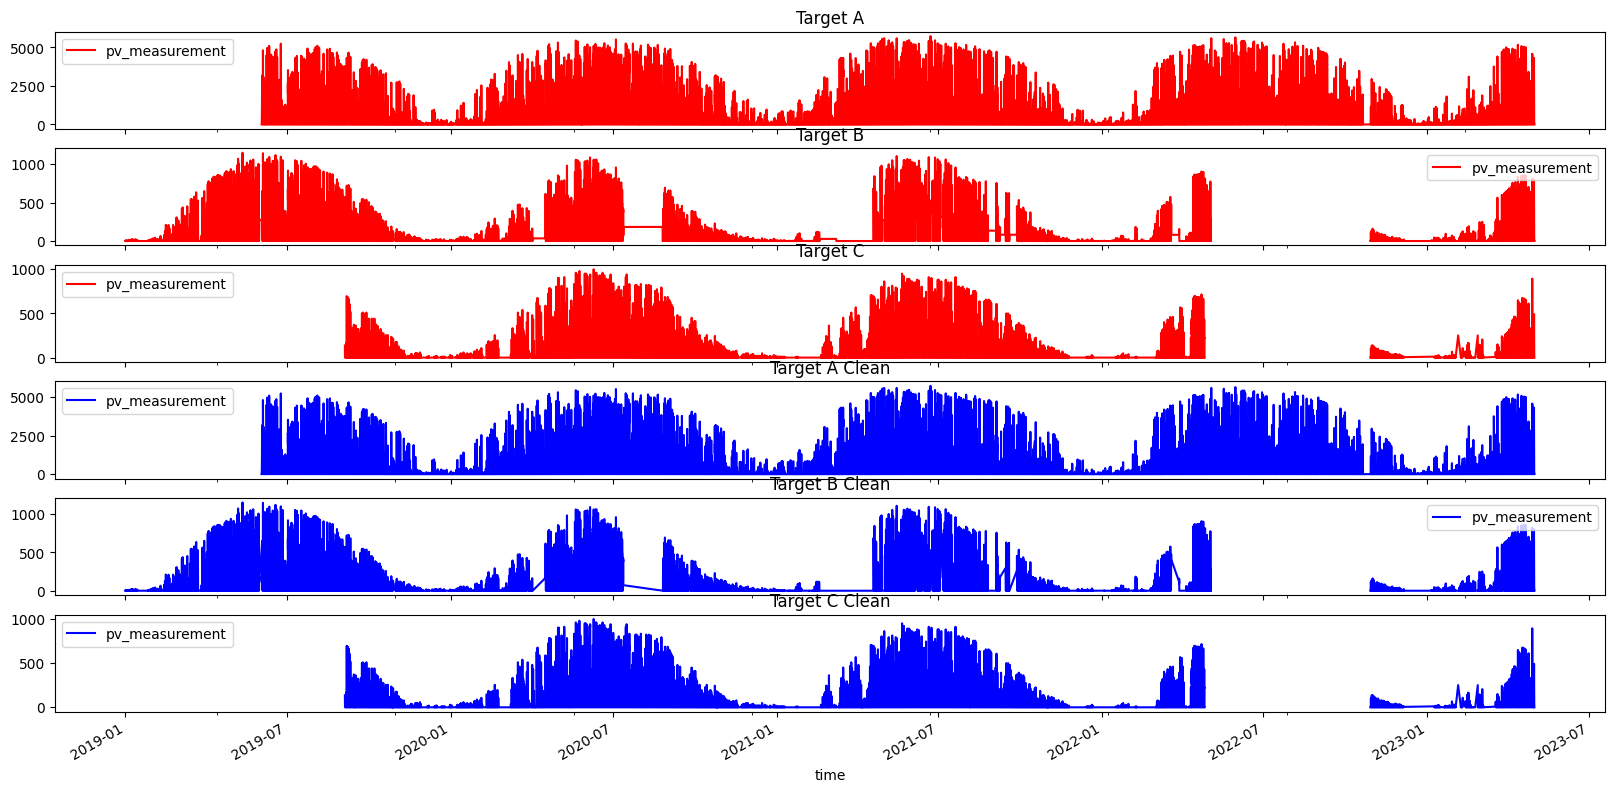

In [8]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data Aggregation

In [9]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])

In [10]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))

x,y:  34061 34061
x,y:  29596 29596
x,y:  26028 26028


In [11]:
# Verifying that all train dataset still have their end data after aggregation in case of allignment issue
for x in X_train:
    print(x["date_forecast"].tail())

34056   2023-04-30 19:00:00
34057   2023-04-30 20:00:00
34058   2023-04-30 21:00:00
34059   2023-04-30 22:00:00
34060   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[us]
29591   2023-04-30 19:00:00
29592   2023-04-30 20:00:00
29593   2023-04-30 21:00:00
29594   2023-04-30 22:00:00
29595   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[us]
26023   2023-04-30 19:00:00
26024   2023-04-30 20:00:00
26025   2023-04-30 21:00:00
26026   2023-04-30 22:00:00
26027   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[us]


# Feature engineering

In [12]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
     temp = pd.concat((train, test), axis=0, ignore_index=True)
     index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
     return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i]['above_298_kelvin'] = np.where(X_train[i]['t_1000hPa:K'] > 298, 1, 0) 
     X_frames_test[i]['above_298_kelvin'] = np.where(X_frames_test[i]['t_1000hPa:K'] > 298, 1, 0) 
     #X_train[i].drop(columns=['absolute_humidity_2m:gm3'], inplace=True)
     #X_frames_test[i].drop(columns=['absolute_humidity_2m:gm3'], inplace=True) # Negligable??
     #X_train[i].drop(columns=['date_forecast'], inplace=True)
     #X_frames_test[i].drop(columns=['date_forecast'], inplace=True)


Combine features

In [13]:
def combine_features(df, listOfFeaturesToCombine):
    for features in listOfFeaturesToCombine:
        new_col_name = features[0] + '_mean'
        df[new_col_name] = df[features].mean(axis=1)
        #df.drop(columns=features, inplace=True)
    return df

listOfFeaturesToCombine = [['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'],
                            ["diffuse_rad:W", "direct_rad:W"], 
                           ["diffuse_rad_1h:J", "direct_rad_1h:J"],
                    ]
for i in range(len(X_train)):
    X_train[i] = combine_features(X_train[i], listOfFeaturesToCombine)
    X_frames_test[i] = combine_features(X_frames_test[i], listOfFeaturesToCombine)

Multiply Cloud_coverage's flipped values with clear_sky_energy

In [14]:
## Multiplying effective cloud coverage with clear sky radiation
from data_func.feature_engineering.combine import multiply_columns

def flip_percent(x):
    return (x-100)*-1

for i in range(len(X_train)):
    A = X_train[i]['effective_cloud_cover:p'].apply(flip_percent)
    B = X_train[i]['clear_sky_energy_1h:J']
    AT = X_frames_test[i]['effective_cloud_cover:p'].apply(flip_percent)
    BT = X_frames_test[i]['clear_sky_energy_1h:J']

    X_train[i]['COMB_clear_sky_energy_X_eff_cloud_cover'] = multiply_columns(A, B)
    X_frames_test[i]['COMB_clear_sky_energy_X_eff_cloud_cover'] =  multiply_columns(AT, BT)

In [15]:
from math import sin, radians
def sinus_degrees(x):
    return sin(radians(x))

for i in range(len(X_train)):
    A = X_train[i]['sun_elevation:d'].apply(sinus_degrees)
    B = X_train[i]['air_density_2m:kgm3']
    AT = X_frames_test[i]['sun_elevation:d'].apply(sinus_degrees)
    BT = X_frames_test[i]['air_density_2m:kgm3']

    X_train[i]['COMB_sun_elevation_air_density'] = multiply_columns(A, B)
    X_frames_test[i]['COMB_sun_elevation_air_density'] =  multiply_columns(AT, BT)

In [16]:
X_frames_test[0].describe().transpose()

,count,mean,min,25%,50%,75%,max,std
date_forecast,720,2023-06-05 21:54:00,2023-05-01 00:00:00,2023-05-23 11:45:00,2023-06-03 23:30:00,2023-06-19 11:15:00,2023-07-03 23:00:00,NaN
is_day:idx,720.0,0.773611,0.0,1.0,1.0,1.0,1.0,0.418785
is_in_shadow:idx,720.0,0.223611,0.0,0.0,0.0,0.0,1.0,0.416954
absolute_humidity_2m:gm3,720.0,8.205903,3.2,6.69375,8.05,9.98125,13.675,2.178425
air_density_2m:kgm3,720.0,1.23315,1.151,1.209,1.238625,1.26,1.29975,0.032103
...,...,...,...,...,...,...,...,...
msl_pressure:hPa_mean,720.0,1011.595459,981.224976,1006.287552,1015.284424,1018.703094,1024.243652,9.720791
diffuse_rad:W_mean,720.0,99.84201,0.0,4.534375,60.937498,171.668747,382.462494,107.507828
diffuse_rad_1h:J_mean,720.0,359430.625,0.0,22751.871094,231012.140625,594694.328125,1365011.25,382736.5625
COMB_clear_sky_energy_X_eff_cloud_cover,720.0,40757449.419796,-0.0,-0.0,2416627.26153,54637094.837217,298219150.0,67626795.937324


## Data Cleaning

In [17]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,6127,4588,5122
cloud_base_agl:m,2363,2025,2199
snow_density:kgm3,32921,28040,24561


In [18]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720
precip_type_5min:idx_5,720,720,720


In [19]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)

In [20]:
drop_cols_a = [
    "fresh_snow_12h:cm", 
    "fresh_snow_1h:cm",
    "fresh_snow_24h:cm",
    "fresh_snow_3h:cm",
    "fresh_snow_6h:cm",
    "snow_drift:idx",
    "snow_depth:cm",
    "snow_melt_10min:mm",
    "snow_water:kgm2"
]

X_train[0].drop(columns=drop_cols_a, inplace=True)
X_frames_test[0].drop(columns=drop_cols_a, inplace=True)

# Training the model

In [21]:
x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_train[0], Y_train[0], test_size=0.17, random_state=42)
x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(X_train[1], Y_train[1], test_size=0.17, random_state=42)
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(X_train[2], Y_train[2], test_size=0.17, random_state=42)

In [22]:
from autogluon.tabular import TabularDataset, TabularPredictor

joined_a = pd.merge(x_train_a, y_train_a, left_index=True, right_index=True)
train_a = TabularDataset(joined_a)
predictor = TabularPredictor(label="pv_measurement", eval_metric='mae').fit(train_data=train_a, time_limit=300) #, presets='good_quality', time_limit=3600)

No path specified. Models will be saved in: "AutogluonModels/ag-20231107_103856"
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/ag-20231107_103856"
AutoGluon Version:  0.8.3b20231102
Python Version:     3.11.1
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   394.35 GB / 994.66 GB (39.6%)
Train Data Rows:    28270
Train Data Columns: 53
Label Column: pv_measurement
Preprocessing data ...
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/

[1000]	valid_set's l1: 162.382
[2000]	valid_set's l1: 155.66
[3000]	valid_set's l1: 152.924
[4000]	valid_set's l1: 150.963
[5000]	valid_set's l1: 150.198
[6000]	valid_set's l1: 149.22
[7000]	valid_set's l1: 148.631
[8000]	valid_set's l1: 148.356
[9000]	valid_set's l1: 148.083
[10000]	valid_set's l1: 147.865


	-147.8562	 = Validation score   (-mean_absolute_error)
	44.11s	 = Training   runtime
	0.27s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 253.57s of the 253.57s of remaining time.


[1000]	valid_set's l1: 166.718
[2000]	valid_set's l1: 164.382
[3000]	valid_set's l1: 163.158
[4000]	valid_set's l1: 162.591
[5000]	valid_set's l1: 162.405
[6000]	valid_set's l1: 162.185
[7000]	valid_set's l1: 162.142
[8000]	valid_set's l1: 162.081
[9000]	valid_set's l1: 162.029
[10000]	valid_set's l1: 161.993


	-161.993	 = Validation score   (-mean_absolute_error)
	68.59s	 = Training   runtime
	0.3s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 184.32s of the 184.32s of remaining time.
	-178.4957	 = Validation score   (-mean_absolute_error)
	18.96s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 165.08s of the 165.08s of remaining time.
		
Fitting model: ExtraTreesMSE ... Training model for up to 164.96s of the 164.96s of remaining time.
	-179.4262	 = Validation score   (-mean_absolute_error)
	3.12s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ... Training model for up to 161.56s of the 161.56s of remaining time.
	-177.1922	 = Validation score   (-mean_absolute_error)
	14.96s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ... Training model for up to 146.57s of the 146.57s of remaining time.
		'Booster' object has no attribute 'best_ntree

In [23]:
y_a_test = predictor.predict(x_val_a)

In [24]:
join_val_a = pd.merge(x_val_a, y_val_a, left_index=True, right_index=True)
predictor.leaderboard(join_val_a, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-138.362928,-144.965225,0.850587,0.361719,59.833095,0.001143,0.000206,0.091352,2,True,9
1,LightGBMXT,-141.143430,-147.856198,0.669031,0.267182,44.107937,0.669031,0.267182,44.107937,1,True,3
2,LightGBM,-155.700908,-161.993016,0.837116,0.299672,68.592030,0.837116,0.299672,68.592030,1,True,4
3,NeuralNetTorch,-165.819517,-164.129364,0.034980,0.014106,15.612092,0.034980,0.014106,15.612092,1,True,8
4,NeuralNetFastAI,-174.019088,-177.192236,0.083753,0.012610,14.955695,0.083753,0.012610,14.955695,1,True,7
5,RandomForestMSE,-176.206169,-178.495678,0.251588,0.039065,18.962849,0.251588,0.039065,18.962849,1,True,5
6,ExtraTreesMSE,-178.301640,-179.426158,0.314920,0.037766,3.122147,0.314920,0.037766,3.122147,1,True,6
7,KNeighborsDist,-200.820842,-215.861087,0.145433,0.080225,0.021714,0.145433,0.080225,0.021714,1,True,2
8,KNeighborsUnif,-252.254382,-264.080625,0.145274,0.398924,1.094547,0.145274,0.398924,1.094547,1,True,1


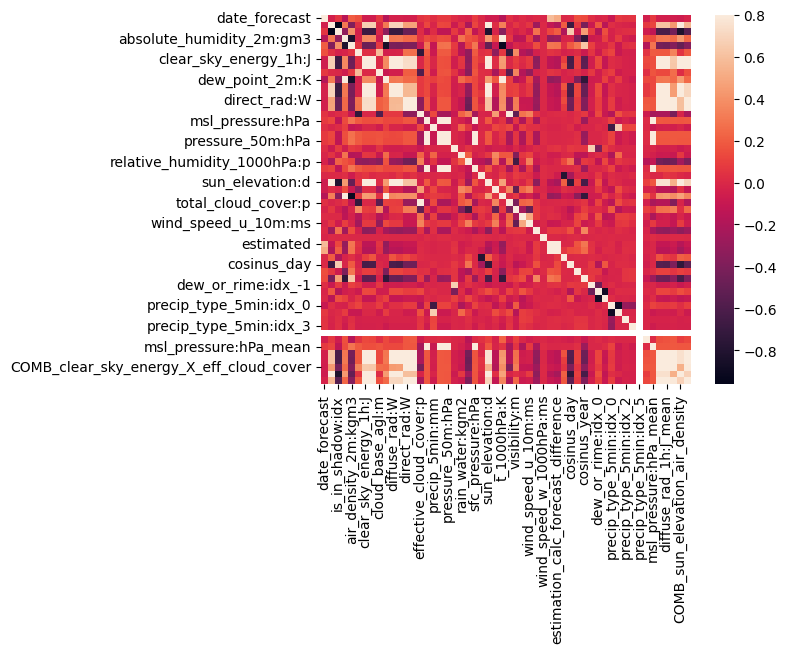

In [25]:
import seaborn as sb
cm = joined_a.corr()
fig = plt.figure()
sb.heatmap(cm, vmax=0.8, square=True)
plt.show()

In [26]:
joined_b = pd.merge(x_train_b, y_train_b, left_index=True, right_index=True)
train_b = TabularDataset(joined_b)
predictor_b = TabularPredictor(label="pv_measurement", eval_metric="mae").fit(train_data=train_b, time_limit=300)#, presets='good_quality', time_limit=3600)

No path specified. Models will be saved in: "AutogluonModels/ag-20231107_104400"
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/ag-20231107_104400"
AutoGluon Version:  0.8.3b20231102
Python Version:     3.11.1
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   393.52 GB / 994.66 GB (39.6%)
Train Data Rows:    24564
Train Data Columns: 62
Label Column: pv_measurement
Preprocessing data ...
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/

[1000]	valid_set's l1: 22.1816
[2000]	valid_set's l1: 21.5252
[3000]	valid_set's l1: 21.1888
[4000]	valid_set's l1: 21.0622


KeyboardInterrupt: 

In [ ]:
y_b_test = predictor_b.predict(x_val_b)

In [ ]:
join_val_b = pd.merge(x_val_b, y_val_b, left_index=True, right_index=True)
predictor_b.leaderboard(join_val_b, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-19.206512,-20.573909,1.439062,0.724084,179.923093,0.000977,0.000196,0.084509,2,True,8
1,LightGBMXT,-19.271527,-20.783040,0.597004,0.283207,119.072817,0.597004,0.283207,119.072817,1,True,3
2,LightGBM,-21.074836,-22.311372,0.739637,0.377711,60.745796,0.739637,0.377711,60.745796,1,True,4
3,RandomForestMSE,-24.373341,-26.386797,0.206173,0.036881,17.287673,0.206173,0.036881,17.287673,1,True,5
4,ExtraTreesMSE,-24.499130,-26.267472,0.186202,0.038110,2.578218,0.186202,0.038110,2.578218,1,True,6
5,KNeighborsDist,-28.507884,-31.100991,0.101444,0.062970,0.019972,0.101444,0.062970,0.019972,1,True,2
6,NeuralNetFastAI,-28.517155,-31.817468,0.065156,0.018857,14.034929,0.065156,0.018857,14.034929,1,True,7
7,KNeighborsUnif,-36.324622,-39.314004,0.182898,0.060777,0.023781,0.182898,0.060777,0.023781,1,True,1


In [ ]:
joined_c = pd.merge(x_train_c, y_train_c, left_index=True, right_index=True)
train_c = TabularDataset(joined_c)
predictor_c = TabularPredictor(label="pv_measurement", eval_metric="mae").fit(train_data=train_c, time_limit=300)#, presets='good_quality', time_limit=3600)

No path specified. Models will be saved in: "AutogluonModels/ag-20231107_100402"
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/ag-20231107_100402"
AutoGluon Version:  0.8.3b20231102
Python Version:     3.11.1
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   399.70 GB / 994.66 GB (40.2%)
Train Data Rows:    21603
Train Data Columns: 62
Label Column: pv_measurement
Preprocessing data ...
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/

[1000]	valid_set's l1: 18.1481
[2000]	valid_set's l1: 17.4986
[3000]	valid_set's l1: 17.2322
[4000]	valid_set's l1: 17.1143
[5000]	valid_set's l1: 17.033
[6000]	valid_set's l1: 16.9956
[7000]	valid_set's l1: 16.9525
[8000]	valid_set's l1: 16.9108
[9000]	valid_set's l1: 16.8949
[10000]	valid_set's l1: 16.8832


	-16.8828	 = Validation score   (-mean_absolute_error)
	128.34s	 = Training   runtime
	0.27s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 170.77s of the 170.76s of remaining time.


[1000]	valid_set's l1: 18.7411
[2000]	valid_set's l1: 18.4984
[3000]	valid_set's l1: 18.4241
[4000]	valid_set's l1: 18.3847
[5000]	valid_set's l1: 18.3784
[6000]	valid_set's l1: 18.3709
[7000]	valid_set's l1: 18.3694
[8000]	valid_set's l1: 18.3656
[9000]	valid_set's l1: 18.3636
[10000]	valid_set's l1: 18.364


	-18.3635	 = Validation score   (-mean_absolute_error)
	60.88s	 = Training   runtime
	0.29s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 109.26s of the 109.26s of remaining time.
	-20.0949	 = Validation score   (-mean_absolute_error)
	14.34s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 94.76s of the 94.76s of remaining time.
		
Fitting model: ExtraTreesMSE ... Training model for up to 94.63s of the 94.63s of remaining time.
	-20.0454	 = Validation score   (-mean_absolute_error)
	2.04s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ... Training model for up to 92.45s of the 92.45s of remaining time.
	-20.1334	 = Validation score   (-mean_absolute_error)
	11.18s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ... Training model for up to 81.25s of the 81.25s of remaining time.
		'Booster' object has no attribute 'best_ntree_limit'
De

In [ ]:
y_c_test = predictor_c.predict(x_val_c)

In [ ]:
join_val_c = pd.merge(x_val_c, y_val_c, left_index=True, right_index=True)
predictor_c.leaderboard(join_val_c, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-15.769352,-16.727692,1.329192,0.634422,200.495857,0.001005,0.000179,0.080255,2,True,8
1,LightGBMXT,-15.967367,-16.882846,0.573287,0.266108,128.338946,0.573287,0.266108,128.338946,1,True,3
2,LightGBM,-17.473259,-18.363505,0.608680,0.293873,60.882780,0.608680,0.293873,60.882780,1,True,4
3,RandomForestMSE,-19.732298,-20.094889,0.151417,0.039104,14.337272,0.151417,0.039104,14.337272,1,True,5
4,ExtraTreesMSE,-19.819256,-20.045353,0.191234,0.038463,2.040199,0.191234,0.038463,2.040199,1,True,6
5,NeuralNetFastAI,-20.021971,-20.133352,0.057897,0.013006,11.177915,0.057897,0.013006,11.177915,1,True,7
6,KNeighborsDist,-22.247017,-25.320996,0.088323,0.061256,0.015961,0.088323,0.061256,0.015961,1,True,2
7,KNeighborsUnif,-28.428497,-31.089990,0.155451,0.049547,0.017830,0.155451,0.049547,0.017830,1,True,1


## Evaluate

In [ ]:
from sklearn.metrics import mean_absolute_error
mae_a = mean_absolute_error(y_val_a, predictor.predict(x_val_a))
print("MAE for A: ", mae_a)
mae_b = mean_absolute_error(y_val_b, y_b_test)
print("MAE for B: ", mae_b)
mae_c = mean_absolute_error(y_val_c, y_c_test)
print("MAE for C: ", mae_c)
print("Mean MAE: ", (mae_a + mae_b + mae_c) / 3)

MAE for A:  139.13633797566334
MAE for B:  19.206511737846757
MAE for C:  15.769352065254601
Mean MAE:  58.037400592921564


In [ ]:
# x_val_a
tulleting = toppstemning

In [ ]:
full_a = pd.merge(X_train[0], Y_train[0], left_index=True, right_index=True)
full_b = pd.merge(X_train[1], Y_train[1], left_index=True, right_index=True)
full_c = pd.merge(X_train[2], Y_train[2], left_index=True, right_index=True)

In [ ]:
pred = predictor.predict(X_train[0][34000:34025])

In [ ]:
goal = Y_train[0][34000:34025]

In [ ]:
g=34000
print(pred[34000])
for i in range(len(pred)):
    print(i, pred[i+g]-goal[i+g], pred[i+g], goal[i+g])

1652.4142
0 185.0141845703124 1652.4142 1467.4
1 -272.51708984375 4308.983 4581.5
2 182.10910156249997 1320.8291 1138.72
3 -65.86789062499997 1237.4121 1303.28
4 -75.96820312500017 1166.5918 1242.5600000000002
5 -22.437951660156273 787.16205 809.6
6 36.30518310546876 340.12518 303.82
7 -10.821026802062988 11.178973 22.0
8 1.3289902210235596 1.3289902 0.0
9 3.9853053092956543 3.9853053 0.0
10 1.227720856666565 1.2277209 0.0
11 0.21145467460155487 0.21145467 0.0
12 3.83919358253479 3.8391936 0.0
13 2.8634252548217773 2.8634253 0.0
14 0.371354877948761 0.37135488 0.0
15 -7.844863739013668 35.495136 43.339999999999996
16 -32.74473907470701 124.77526 157.51999999999998
17 -54.32733154296875 248.17267 302.5
18 -0.9454125976562295 322.0146 322.96
19 5.848666992187532 485.00867 479.15999999999997
20 2.0523217773437636 648.1923 646.14
21 -0.44283691406246817 902.21716 902.66
22 5.1053369140622635 1086.8453 1081.7400000000002
23 29.5643457031249 1374.2043 1344.64
24 -0.048784179687345386 1410.37

In [ ]:
print(goal[11+g], pred[11+g])

0.0 0.21145467


In [ ]:
#X_frames_test[0].drop(columns=drop_cols_a, inplace=True)

In [ ]:
test_pred = predictor.transform_features(X_frames_test[0][0:25])

In [ ]:
predictor.predict(test_pred)

34060       0.311918
34061       3.686449
34062       4.442657
34063       8.783237
34064     255.653198
34065     758.112244
34066    1695.158203
34067    2700.921143
34068    2663.046387
34069    2737.825684
34070    3233.664795
34071    3434.518799
34072    2825.210693
34073    2903.266846
34074    2563.815674
34075    1643.651855
34076    1310.947021
34077     746.387451
34078     181.962204
34079      -0.316178
34080       1.867638
34081       2.378543
34082       4.708968
34083       6.635847
34084       3.483795
Name: pv_measurement, dtype: float32

In [ ]:
X_train[0].tail(25)

,date_forecast,is_day:idx,is_in_shadow:idx,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_point_2m:K,...,sinus_year,cosinus_year,dew_or_rime:idx_-1,dew_or_rime:idx_0,dew_or_rime:idx_1,precip_type_5min:idx_0,precip_type_5min:idx_1,precip_type_5min:idx_2,precip_type_5min:idx_3,precip_type_5min:idx_5
34035,2023-04-29 23:00:00,0,1,4.400,1.27725,4197.399902,0.000000e+00,0.000000,750.224976,271.950012,...,0.887845,-0.460142,0,1,0,1,0,0,0,0
34036,2023-04-30 00:00:00,0,1,4.300,1.28100,2507.550049,0.000000e+00,0.000000,1075.074951,271.700012,...,0.887515,-0.460778,0,1,0,1,0,0,0,0
34037,2023-04-30 01:00:00,0,1,4.300,1.27850,2224.600098,0.000000e+00,0.000000,949.799988,271.650024,...,0.887185,-0.461414,0,1,0,1,0,0,0,0
34038,2023-04-30 02:00:00,0,1,4.300,1.27700,2318.500000,0.000000e+00,0.000000,1700.574951,271.600006,...,0.886854,-0.462050,0,1,0,1,0,0,0,0
34039,2023-04-30 03:00:00,1,0,4.275,1.27600,3395.800049,8.052975e+03,9.950000,2417.175049,271.500000,...,0.886523,-0.462685,0,1,0,1,0,0,0,0
34040,2023-04-30 04:00:00,1,0,4.200,1.27350,2289.975098,1.307704e+05,72.675003,932.099976,271.399994,...,0.886191,-0.463321,0,1,0,1,0,0,0,0
34041,2023-04-30 05:00:00,1,0,4.275,1.26950,4014.899902,4.540071e+05,185.199997,919.950012,271.575012,...,0.885858,-0.463956,0,1,0,0,0,1,0,0
34042,2023-04-30 06:00:00,1,0,4.400,1.26700,2650.449951,9.014685e+05,316.549988,1157.025024,272.000000,...,0.885526,-0.464591,0,1,0,0,0,1,0,0
34043,2023-04-30 07:00:00,1,0,4.650,1.26550,1734.449951,1.374201e+06,445.125000,1026.599976,272.750000,...,0.885192,-0.465225,0,1,0,0,0,1,0,0
34044,2023-04-30 08:00:00,1,0,4.850,1.26475,2351.500000,1.810678e+06,557.125000,732.599976,273.325012,...,0.884859,-0.465860,0,1,0,0,0,1,0,0


In [ ]:
X_frames_test[0].head(25)

,date_forecast,is_day:idx,is_in_shadow:idx,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_point_2m:K,...,sinus_year,cosinus_year,dew_or_rime:idx_-1,dew_or_rime:idx_0,dew_or_rime:idx_1,precip_type_5min:idx_0,precip_type_5min:idx_1,precip_type_5min:idx_2,precip_type_5min:idx_3,precip_type_5min:idx_5
34060,2023-05-01 00:00:00,0,1,4.325,1.28675,912.700012,0.000000e+00,0.000000,1061.550049,271.650024,...,0.879458,-0.475977,0.0,1,0,1,0,0.0,0.0,0.0
34061,2023-05-01 01:00:00,0,1,4.275,1.28600,1482.099976,0.000000e+00,0.000000,1075.100098,271.450012,...,0.879116,-0.476607,0.0,1,0,1,0,0.0,0.0,0.0
34062,2023-05-01 02:00:00,0,1,4.150,1.28375,1791.300049,0.000000e+00,0.000000,1200.400024,271.049988,...,0.878775,-0.477237,0.0,1,0,1,0,0.0,0.0,0.0
34063,2023-05-01 03:00:00,1,0,4.025,1.28200,2312.875000,1.012442e+04,11.675000,1179.849976,270.649994,...,0.878432,-0.477867,0.0,1,0,1,0,0.0,0.0,0.0
34064,2023-05-01 04:00:00,1,0,3.900,1.28100,2198.299805,1.417486e+05,76.875000,920.049988,270.375000,...,0.878090,-0.478496,0.0,1,0,1,0,0.0,0.0,0.0
34065,2023-05-01 05:00:00,1,0,4.000,1.27600,1957.625000,4.716072e+05,190.574997,1419.300049,270.549988,...,0.877746,-0.479126,0.0,1,0,1,0,0.0,0.0,0.0
34066,2023-05-01 06:00:00,1,0,4.000,1.26825,1903.300049,9.212486e+05,322.149994,1299.400024,270.824982,...,0.877403,-0.479755,0.0,1,0,1,0,0.0,0.0,0.0
34067,2023-05-01 07:00:00,1,0,4.000,1.26250,20000.000000,1.394139e+06,450.575012,743.299988,270.899994,...,0.877059,-0.480383,0.0,1,0,1,0,0.0,0.0,0.0
34068,2023-05-01 08:00:00,1,0,4.100,1.25975,1381.199829,1.830129e+06,562.450012,805.375000,271.024994,...,0.876714,-0.481012,0.0,1,0,1,0,0.0,0.0,0.0
34069,2023-05-01 09:00:00,1,0,4.100,1.25850,1429.824951,2.187716e+06,647.900024,884.950012,271.049988,...,0.876369,-0.481640,0.0,1,0,1,0,0.0,0.0,0.0


In [ ]:
#predictions before full training
pred_split_a = predictor.predict(X_frames_test[0])
pred_split_b = predictor_b.predict(X_frames_test[1])
pred_split_c = predictor_c.predict(X_frames_test[2])

# Make predictions

In [ ]:
# Do some more stuff
y_pred = np.concatenate((pred_split_a, pred_split_b, pred_split_c), axis=0)

print(len(y_pred))

2160


In [ ]:
y_pred[0:10]

array([3.1191832e-01, 3.6864493e+00, 4.4426565e+00, 8.7832375e+00,
       2.5565320e+02, 7.5811224e+02, 1.6951582e+03, 2.7009211e+03,
       2.6630464e+03, 2.7378257e+03], dtype=float32)

In [ ]:
for i in range(len(y_pred)):
     if y_pred[i] < 1: 
         y_pred[i] = 0

# Evaluate prediction

# Create submission

In [ ]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/autogluon_best_2_3_full_submission.csv', index=False)

In [ ]:
#combine submission
res = []
comb = pd.read_csv("../best_notebooks/submissions/submission_xg.csv")
for i in range(len(comb)):
    res.append((comb["prediction"].iloc[i] + submission["prediction"].iloc[i])/2)

new_sub = pd.DataFrame()
new_sub["id"] = submission["id"]
new_sub["prediction"] = res

new_sub.to_csv("./submissions/sub_combined_ag_xg_2.csv", index = False)